In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import urllib.request

In [2]:
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_text.npy", filename="train_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_text.npy", filename="test_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_label.npy", filename="train_label.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_label.npy", filename="test_label.npy")

('test_label.npy', <http.client.HTTPMessage at 0x19eac044708>)

In [3]:
old = np.load
np.load = lambda *a,**k : old(*a, allow_pickle=True, **k)

In [4]:
intent_train=np.load(open('train_text.npy', 'rb')).tolist()
label_train=np.load(open('train_label.npy', 'rb')).tolist()
intent_test=np.load(open('test_text.npy', 'rb')).tolist()
label_test=np.load(open('test_label.npy', 'rb')).tolist()

In [6]:
print("훈련용 문장 수 :", len(intent_train))
print("훈련용 레이블 수 :", len(label_train))
print("테스트용 문장 수 :", len(intent_test))
print("테스트용 레이블 수 :", len(label_test))

훈련용 문장 수 : 11784
훈련용 레이블 수 : 11784
테스트용 문장 수 : 600
테스트용 레이블 수 : 600


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

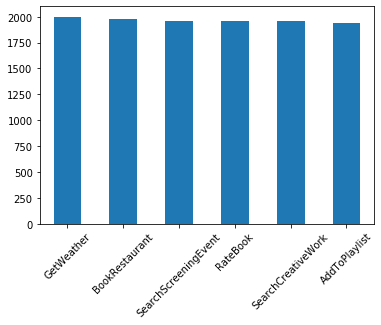

In [12]:
# 훈련데이터에 존재하는 6개의 카테고리 / 각 데이터당 2000개씩 존재
temp=pd.Series(label_train)
temp.value_counts().plot(kind='bar')
plt.xticks(rotation=45)

In [14]:
#6개 항목 라벨인코딩

idx_encode=preprocessing.LabelEncoder()
idx_encode.fit(label_train)

label_train = idx_encode.transform(label_train)
label_test = idx_encode.transform(label_test)

label_idx=dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))

In [15]:
print(label_idx)

{'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences=tokenizer.texts_to_sequences(intent_train)
sequences[:5]

[[11, 191, 61, 4, 1, 4013, 1141, 1572, 15],
 [11, 2624, 1573, 3, 14, 15, 939, 82, 256, 188, 548],
 [11, 187, 42, 2625, 4014, 4, 1968],
 [11, 2626, 22, 2627, 4, 14, 192, 27],
 [11, 92, 4, 14, 651, 520, 195]]

In [18]:
# 단어 집합 크기 : 9870 / 최대길이 : 35 / 평균길이 : 9.364392396469789
word_index=tokenizer.word_index
vocab_size=len(word_index)+1
print("단어집합크기 :", vocab_size)

단어집합크기 : 9870


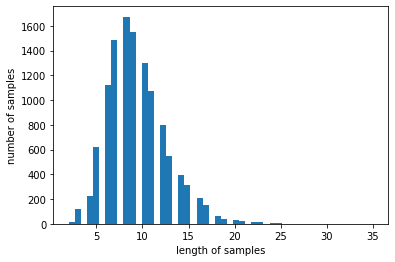

In [20]:
plt.hist([len(s) for s in sequences],bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
# 최대길이 35 -> 패딩 35
max_len = 35
intent_train = pad_sequences(sequences, maxlen=max_len) # 길이 맞춰주는 작업 17784,35
label_train = to_categorical(np.asarray(label_train)) #17784,6

In [23]:
indices = np.arange(intent_train.shape[0]) # 해당 크기 행렬로 반환
np.random.shuffle(indices)

In [24]:
intent_train = intent_train[indices]
label_train = label_train[indices]

In [25]:
n_of_val=int(0.1*intent_train.shape[0]) # 1178

In [27]:
xtrain = intent_train[:n_of_val]
ytrain = label_train[:n_of_val]
xval = intent_train[-n_of_val:]
yval = label_train[-n_of_val:]
xtest = intent_test
ytest = label_test

In [30]:
print(intent_train)

[[   0    0    0 ...    6    1 1073]
 [   0    0    0 ...  121   76   32]
 [   0    0    0 ...    7  266 6195]
 ...
 [   0    0    0 ...    2 1460   26]
 [   0    0    0 ...    1 2229 8586]
 [   0    0    0 ...    1 7775  121]]


In [31]:
embedding_dict = dict()
f = open(os.path.join('glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [32]:
# 사전훈련 임베딩 벡터 차원 100
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
np.shape(embedding_matrix)

(9870, 100)

In [46]:
# 훈련데이터에 있는 단어들과 맵핑되는 사전 임베딩 벡터값 테이블에 저장
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [47]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [48]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(100))
model.add(Dense(6, activation='softmax'))

In [49]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         987000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 1,068,006
Trainable params: 1,068,006
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(xtrain, ytrain, epochs=10, batch_size=60, validation_data=(xval, yval))

Epoch 1/10
20/20 [==============================] - 2s 117ms/step - loss: 1.7377 - acc: 0.3421 - val_loss: 1.6294 - val_acc: 0.5637
Epoch 2/10
20/20 [==============================] - 2s 86ms/step - loss: 1.3208 - acc: 0.6087 - val_loss: 1.0462 - val_acc: 0.7742
Epoch 3/10
20/20 [==============================] - 2s 90ms/step - loss: 0.7052 - acc: 0.8480 - val_loss: 0.5575 - val_acc: 0.8693
Epoch 4/10
20/20 [==============================] - 2s 85ms/step - loss: 0.3006 - acc: 0.9474 - val_loss: 0.3157 - val_acc: 0.8964
Epoch 5/10
20/20 [==============================] - 2s 87ms/step - loss: 0.1412 - acc: 0.9711 - val_loss: 0.1941 - val_acc: 0.9482
Epoch 6/10
20/20 [==============================] - 2s 88ms/step - loss: 0.0741 - acc: 0.9822 - val_loss: 0.1664 - val_acc: 0.9533
Epoch 7/10
20/20 [==============================] - 2s 87ms/step - loss: 0.0603 - acc: 0.9873 - val_loss: 0.2010 - val_acc: 0.9338
Epoch 8/10
20/20 [==============================] - 2s 87ms/step - loss: 0.0394 - 

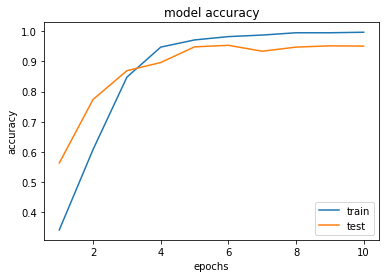

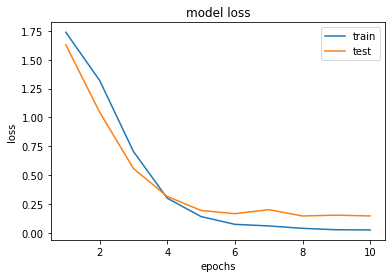

In [52]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [53]:
xtest = tokenizer.texts_to_sequences(xtest)
xtest = pad_sequences(xtest, maxlen=max_len)

In [54]:
ypredicted = model.predict(xtest)
ypredicted = ypredicted.argmax(axis=-1) # 예측된 정수 시퀀스로 변환

In [55]:
ypredicted = idx_encode.inverse_transform(ypredicted) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환
ytest = idx_encode.inverse_transform(ytest) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환

In [57]:
print('accuracy: ', sum(ypredicted == ytest) / len(ytest))
print("Precision, Recall and F1-Score:\n\n", classification_report(ytest, ypredicted))

accuracy:  0.9583333333333334
Precision, Recall and F1-Score:

                       precision    recall  f1-score   support

       AddToPlaylist       1.00      1.00      1.00       100
      BookRestaurant       0.99      0.98      0.98       100
          GetWeather       0.99      0.97      0.98       100
            RateBook       0.99      0.99      0.99       100
  SearchCreativeWork       0.82      0.97      0.89       100
SearchScreeningEvent       0.99      0.84      0.91       100

            accuracy                           0.96       600
           macro avg       0.96      0.96      0.96       600
        weighted avg       0.96      0.96      0.96       600

